In [1]:
# This notebook is for diffusion parcellation using HCPMMP cortical parcellation matrix and gradient approach for HCP 7Tsubj7TDWI subjects (N=173).

# Includes:
#     Connectivity matrix
#     Gradients calculation
#     Variance explained
#     BF gradient weighted Cortical Projection
#     comparsion with BF stereostatic atlas

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import plotly.graph_objects as go

### Setting the path

In [2]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
# get the current notebook path
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj/"
fig_path = main_path + "/HumanBF-Parcellation/results/Diff_7Tsubj/figures/"

### Get the connectivity matrix

In [4]:
# load npz data
data = load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tgroup_connMap.npz')
correlation = data['conn_group']

In [5]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [6]:
# Reshape and concatenate subjects
#corr = np.moveaxis(correlation,0,2)
#corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
#corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
#corr_concat[np.isnan(corr_concat)] = 1

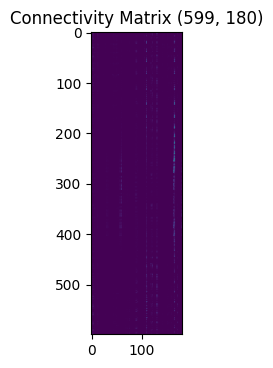

In [6]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avg)
ax.set_title('Connectivity Matrix {}'.format(corr_avg.shape))
plt.show()

### Calculate Gradient

In [11]:
n_components=100

In [12]:
#Average data
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=n_components, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(corr_avg))

GradientMaps(kernel='normalized_angle', n_components=100, random_state=0)


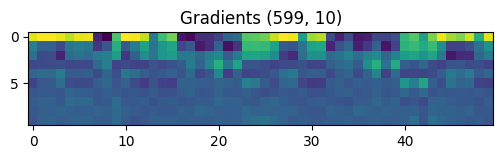

In [17]:
# Plot this gradients.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

In [18]:
# save the gradient
pd.DataFrame(gm.gradients_).to_csv(results_path + f'Diff_7Tsubj_gradients-{n_components}_seed-BASF_1p6mm.csv', index=False)

In [19]:
# save the BF gradients niftis
# get seed data
seed_file = (data_path + 'seed_1p6mm.nii.gz')
seed = nib.load(seed_file)
seed_vol = seed.get_fdata()
mask = data['mask']
affine = data['affine']

for gradi in range(10):

    grad_vol = np.zeros(mask.shape)
    grad_vol[mask > 0] = gm.gradients_[:,gradi]
    
    grad_nib = nib.Nifti1Image(grad_vol,affine,header=seed.header)
    grad_nib.to_filename(results_path + f'Diff_7Tsubj_gradient_{gradi+1}.nii.gz')

### Calculate Variance

/tmp/ipykernel_4723/2828249712.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


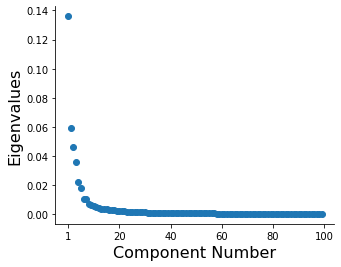

In [13]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Eigenvalues', fontsize=16)
plt.savefig(fig_path + f'Diff_7Tsubj_Gradient_eiganvalue_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_4723/1422339611.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


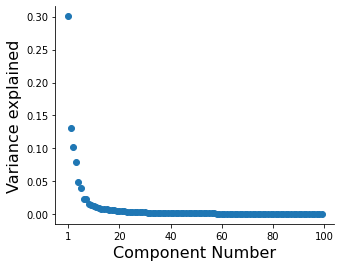

In [14]:
variance = gm.lambdas_ / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(variance.size), variance)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Variance explained', fontsize=16)
plt.savefig(fig_path + f'Diff_7Tsubj_Gradient_variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
pd.DataFrame(variance).to_csv(results_path + f'Diff_7Tsubj_gradients_variance_gm-{n_components}.csv', index=False)

/tmp/ipykernel_4723/3480232736.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0,1,20,40,60,80,100])


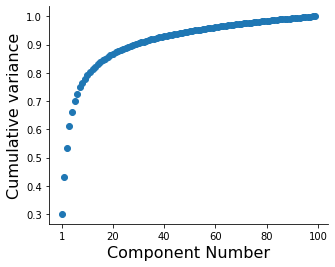

In [15]:
cum_var = np.cumsum(gm.lambdas_) / np.sum(gm.lambdas_)
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(cum_var.size), cum_var)
ax.set_xticklabels(labels=[0,1,20,40,60,80,100])
#ax.set_xticklabels(labels=[0,1,3,5,7,9,10])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Component Number', fontsize=16)
ax.set_ylabel('Cumulative variance', fontsize=16)
plt.savefig(fig_path + f'Diff_7Tsubj_Gradient_cumulative-variance_gm-{n_components}.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualize Gradients

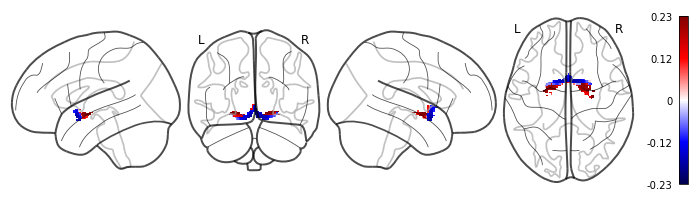

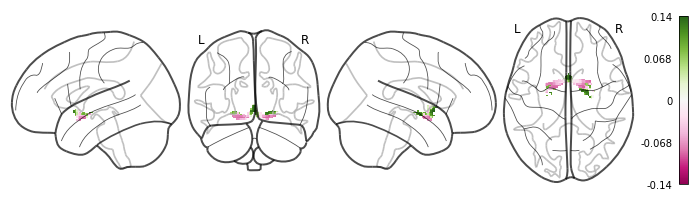

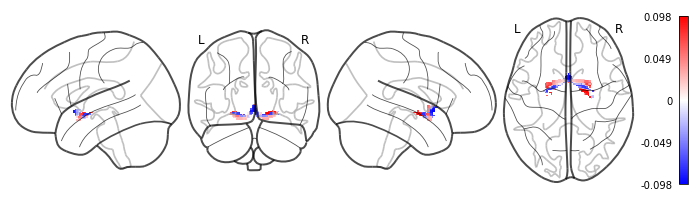

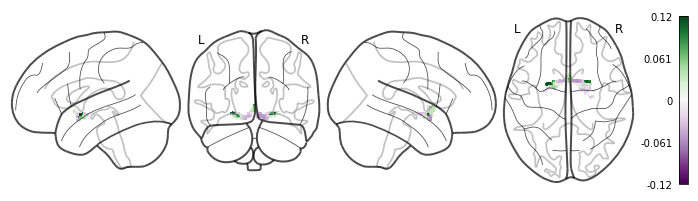

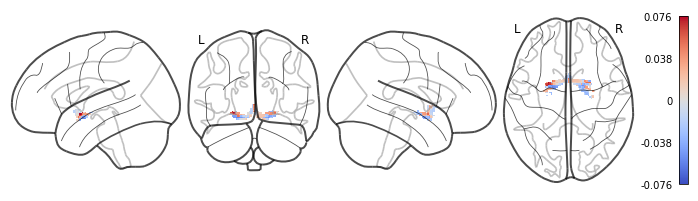

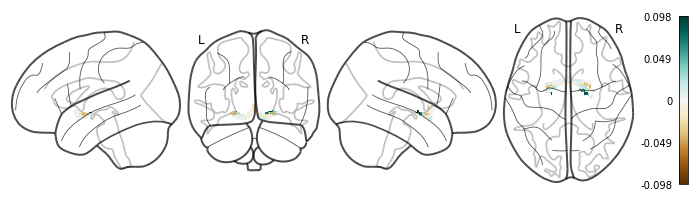

In [24]:
colors = ['seismic','PiYG','bwr','PRGn','coolwarm','BrBG']

for gradi in range(6):
    grad_nib = nib.load(results_path + f'Diff_7Tsubj_gradient_{gradi+1}.nii.gz')
    color = matplotlib.cm.get_cmap(colors[gradi])
    plot_glass_brain(grad_nib, colorbar=True, display_mode='lyrz', plot_abs=False, cmap=color)
    plt.savefig(fig_path + f'Diff_7Tsubj_Gradient_{gradi+1}.png',dpi=300)

#### scatter plot BF

In [28]:
fname = (results_path + 'Diff_7Tsubj_gradient_{0}.nii.gz')

In [29]:
G_idx = {}
G_values = {}
for g in range(1,7):
    G_nii = nib.load(fname.format(g)).get_fdata()
    G_idx[g] = np.argwhere(G_nii)
    G_values[g] = G_nii[G_idx[g][:,0], G_idx[g][:,1], G_idx[g][:,2]].flatten()

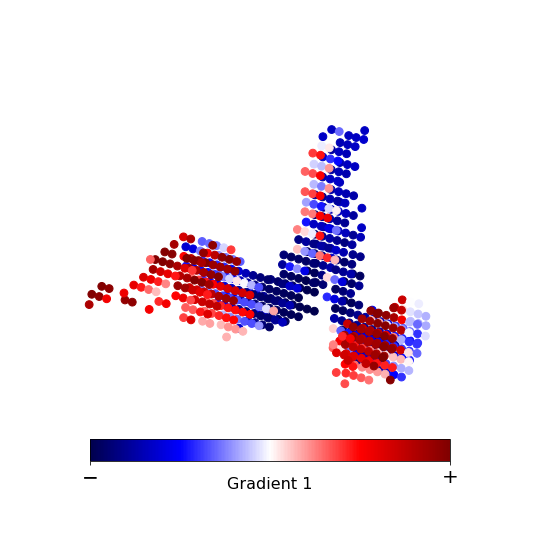

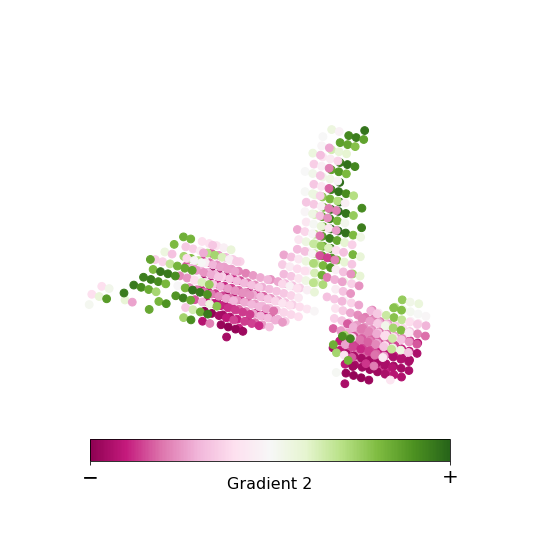

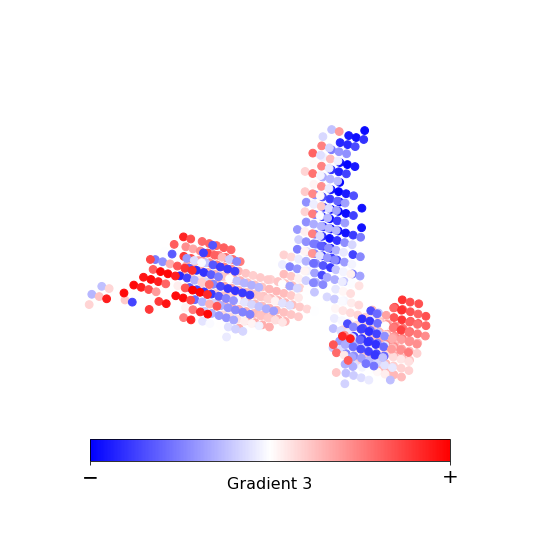

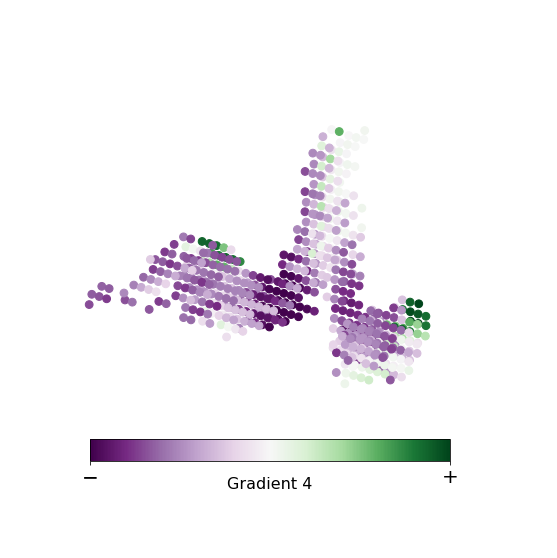

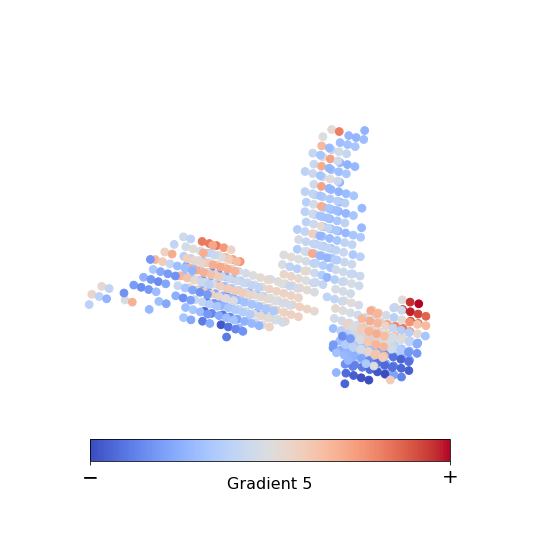

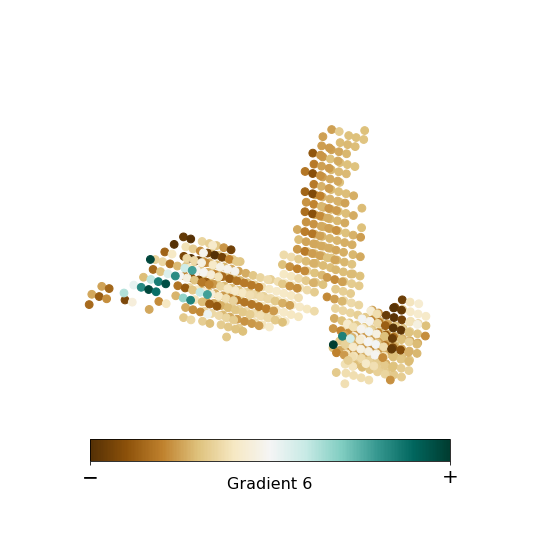

In [30]:
colors = ['seismic','seismic','PiYG','bwr','PRGn','coolwarm','BrBG']

for g in range(1,7):
    # Plot using 3D scatter plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.dist=10
    ax.set_axis_off()
    
    ax.scatter(
        G_idx[g][:,0],
        G_idx[g][:,1],
        G_idx[g][:,2],
        s=60, alpha=1,
        cmap=colors[g], vmin=G_values[g].min(), vmax=G_values[g].max(), 
        c=G_values[g]
    )
    # Add legend    
    norm = matplotlib.colors.Normalize(G_values[g].min(), G_values[g].max())
    cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
    cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colors[g]), 
                      ticks=[G_values[g].min(), G_values[g].max()], cax=cb_ax, orientation='horizontal')
    cb.set_label(f"Gradient {g}", fontsize=16, labelpad=-10)
    cb.ax.set_xticklabels(['−','+'], fontsize=20) 
    
    plt.savefig(fig_path + f'Fused-matrix_Gradient_{g}_scatterplot.png', dpi=300, bbox_inches='tight')
    plt.show()

### BF-gradient weighted corical projection

In [31]:
# expand the corr_avg to match 360 cortical targets and get log-sclaed avgFC
corr_avgFC = np.concatenate((corr_avg,corr_avg), axis=1)
log_corr_avgFC = np.log(corr_avgFC)

In [32]:
pd.DataFrame(corr_avgFC).to_csv(results_path + f'Diff_7Tsubj_corr-avgFC.csv', index=False)
pd.DataFrame(log_corr_avgFC).to_csv(results_path + f'Diff_7Tsubj_log-corr-avgFC.csv', index=False)

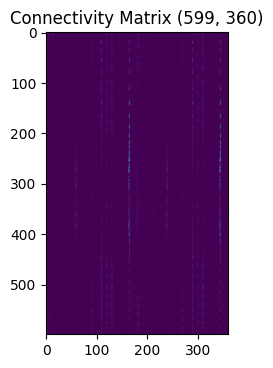

In [33]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avgFC)
ax.set_title('Connectivity Matrix {}'.format(corr_avgFC.shape))
plt.show()

In [34]:
G_Ctx = {}
for g in range(6):
    G_Ctx[g] = np.zeros(corr_avgFC.shape)
    for i in range(len(gm.gradients_[:,g])):
        G_Ctx[g][i,:] = log_corr_avgFC[i,:]*gm.gradients_[i,g]

In [35]:
np.savez(results_path + 'Diff_7Tsubj_Gradient-weighted_CorticalConnectivity.npz', G1_Ctx=G_Ctx[0], G2_Ctx=G_Ctx[1], G3_Ctx=G_Ctx[2], G4_Ctx=G_Ctx[3], G5_Ctx=G_Ctx[4], G6_Ctx=G_Ctx[5])

In [36]:
Gfc = {}
for g in range(6):
    Gfc[g] = np.nanmean(G_Ctx[g], axis=0).reshape([360,1])

In [37]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [38]:
G_cortex = {}
for g in range(6):
    G_cortex[g] = map_to_labels(Gfc[g].reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [39]:
colors = ['seismic','PiYG','bwr','PRGn','coolwarm','BrBG']

In [40]:
for gradi in range(6):
    plot_hemispheres(surf_lh, surf_rh, array_name=[G_cortex[gradi]], label_text=[f'Gradient-{gradi+1}'], 
                     size=(800, 200),  cmap=[colors[gradi]], color_bar=True, embed_nb=True, 
                     layout_style='row', color_range='sym', zoom=1,
                     screenshot=True, filename=fig_path+f'Diff_7Tsubj_Grad-{gradi+1}_weighted_cortex.png' )

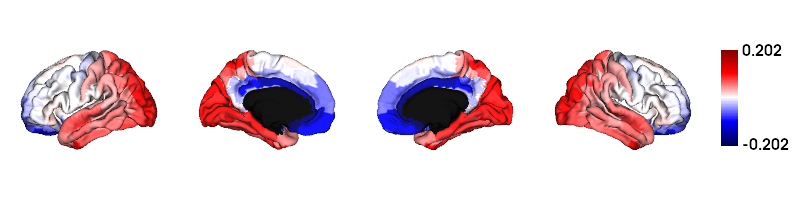

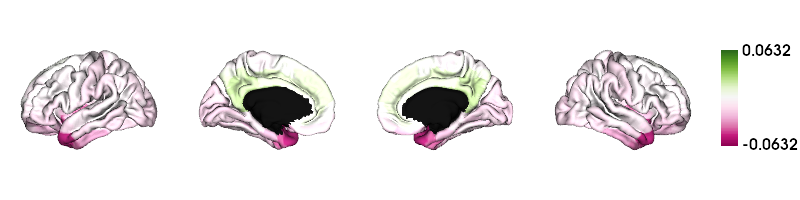

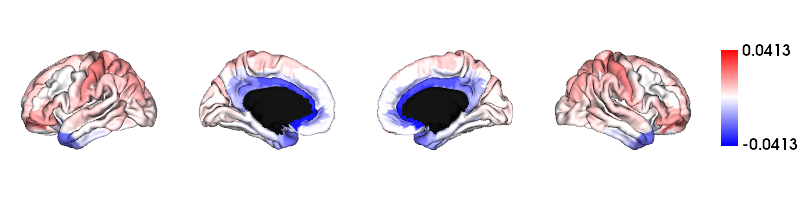

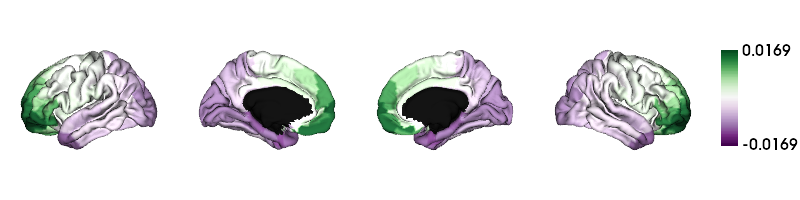

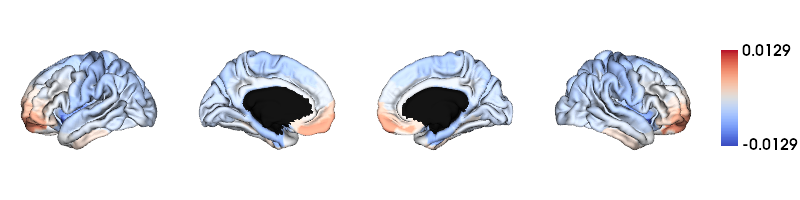

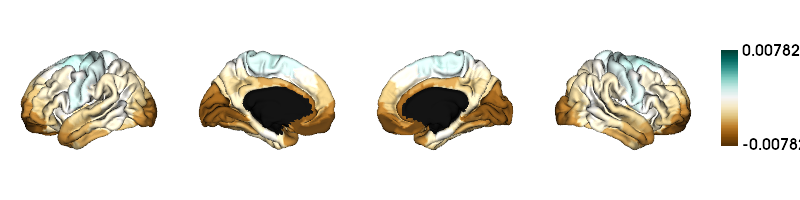

In [41]:
for gradi in range(6):
    fig = plot_hemispheres(surf_lh, surf_rh, array_name=[G_cortex[gradi]],
                           size=(800, 200), cmap=[colors[gradi]], color_range='sym', color_bar=True, embed_nb=True)
    display(fig)

In [42]:
# Save the cortical projection as gii files

for g in range(0, len(G_cortex)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][:10242].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Diff_7Tsubj_Gradient-'+str(g+1)+'_weighted_L_fsa-10k.gii')

for g in range(0, len(G_cortex)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(G_cortex[g][10242:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Diff_7Tsubj_Gradient-'+str(g+1)+'_weighted_R_fsa-10k.gii')

### Visualize BF-gradient weighted cortical projection

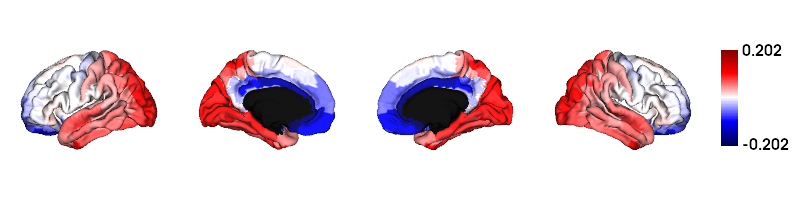

In [43]:
grad_L = images.load_gifti(results_path+'Diff_7Tsubj_Gradient-1_weighted_L_fsa-10k.gii')
grad_R = images.load_gifti(results_path+'Diff_7Tsubj_Gradient-1_weighted_R_fsa-10k.gii')
grad_L_data = grad_L.agg_data()
grad_R_data = grad_R.agg_data()
grad_data = np.concatenate((grad_L_data, grad_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[grad_data], size=(800, 200), cmap=['seismic'], color_range='sym', color_bar=True, embed_nb=True)

### Gradient x Atlas subregion

In [44]:
subBF_nib = nib.load(data_path+'fullBF_MNI6Asym_1p6mm_dseg.nii.gz')
subBF_vol = subBF_nib.get_fdata()

In [45]:
grad_0_nib = nib.load(results_path +'Diff_7Tsubj_gradient_1.nii.gz')
grad_0_vol = grad_0_nib.get_fdata()
grad_1_nib = nib.load(results_path +'Diff_7Tsubj_gradient_2.nii.gz')
grad_1_vol = grad_1_nib.get_fdata()

In [46]:
grad1_Ch123 = grad_0_vol[subBF_vol == 1]
grad1_Ch4 = grad_0_vol[subBF_vol == 2]
grad1_Ch4p = grad_0_vol[subBF_vol == 3]

grad2_Ch123 = grad_1_vol[subBF_vol == 1]
grad2_Ch4 = grad_1_vol[subBF_vol == 2]
grad2_Ch4p = grad_1_vol[subBF_vol == 3]

In [47]:
grad1 = [grad1_Ch123, grad1_Ch4, grad1_Ch4p]
grad2 = [grad2_Ch123, grad2_Ch4, grad2_Ch4p]

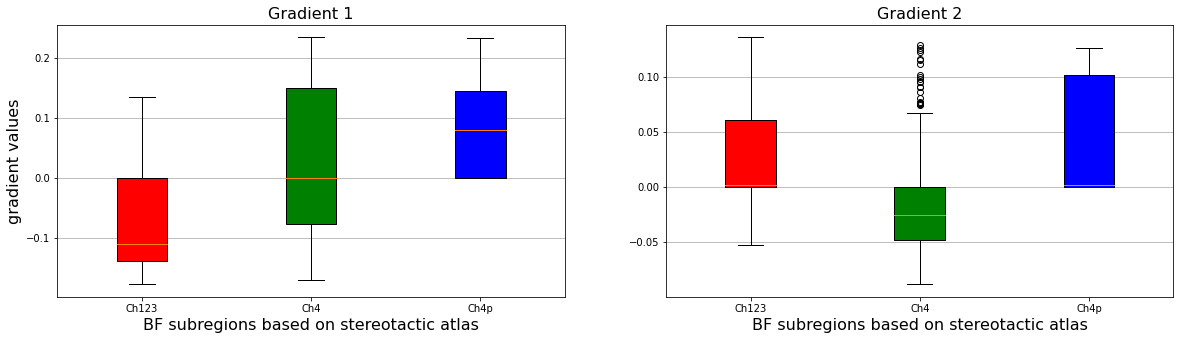

In [48]:
labels = ['Ch123', 'Ch4', 'Ch4p']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# rectangular box plot
bplot1 = ax1.boxplot(grad1,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Gradient 1', fontsize=16)

bplot2 = ax2.boxplot(grad2,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Gradient 2', fontsize=16)

# fill with colors
colors = ['red', 'green', 'blue']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('BF subregions based on stereotactic atlas', fontsize=16)

for ax in [ax1]:
    ax.set_ylabel('gradient values', fontsize=16)

plt.savefig(fig_path+f'Diff_7Tsubj_gradientxatlas.png', dpi=300, bbox_inches='tight')
plt.show()